In [1]:
##
## Import various modules -- can tidy up later
##
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib tk
import sys
sys.path.insert(0,r"E:\Simon_Files")
# import utils
import os
import re
from scipy import io
import pickle
import cmocean
import copy
# import iris_lmsalpy
# import astropy
import pandas as pd
# import hissw
# from astropy.coordinates import SkyCoord
# import astropy.units as u
# from sunpy.coordinates import frames
# import sunpy.map
import scipy as sp
from astropy.io import fits

In [2]:
#data read in - will take a moment
dir1 = r'E:\\Simon_Files\\oct252014\\'
file_sg = dir1+r'IRIS_SG_Oct_25_siiv1394_expcorr.pkl'
with open(file_sg, 'rb') as output:  
    sg_siiv1394_dict = pickle.load(output)
# file_sg = dir1+'IRIS_SG_2014_Sept_10_oi_expcorr.pkl'
# with open(file_sg, 'rb') as output:  
#     sg_oi_dict = pickle.load(output)

In [3]:
print(sg_siiv1394_dict['data'].shape)

ny = sg_siiv1394_dict['data'].shape[0]
nt = sg_siiv1394_dict['data'].shape[1]
nw = sg_siiv1394_dict['data'].shape[2]
ns = sg_siiv1394_dict['data'].shape[3]

(387, 2040, 1020, 1)


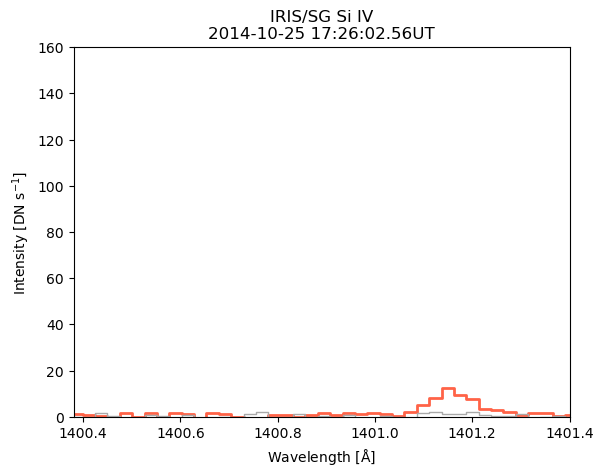

In [7]:
#example spectra
tind = 1650
tind_pf = 0 ## the pre-flare spectra to overlay in grey
sind = 0 ## the slit number, for sit-and-stare this is always 0
yind = 48 ## Lets look at pixel 335 along the slit
plt.plot(sg_siiv1394_dict['wl'][:,sind], 
         sg_siiv1394_dict['data'][yind,tind,:,sind],
         color = 'tomato',
         drawstyle = 'steps-mid',
         linewidth = 2)
plt.plot(sg_siiv1394_dict['wl'][:,sind], 
         sg_siiv1394_dict['data'][yind,tind_pf,:,sind],
         color = 'darkgrey',
         drawstyle = 'steps-mid',
         linewidth = 1)
plt.xlabel('Wavelength [$\mathrm{\AA}$]')
plt.ylabel('Intensity [DN s$^{-1}$]')
plt.title('IRIS/SG Si IV\n'+sg_siiv1394_dict['hdr']['dateobs'][tind,sind]+'UT')
plt.yscale('linear')
plt.xlim(lowerlim,upperlim) #if wl defined
plt.ylim(0,160)
plt.show()

# plt.plot(sg_oi_dict['wl'][:,sind], 
#          sg_oi_dict['data'][yind,tind,:,sind],
#          color = 'dodgerblue',
#          drawstyle = 'steps-mid',
#          linewidth = 2)
# plt.plot(sg_oi_dict['wl'][:,sind], 
#          sg_oi_dict['data'][yind,tind_pf,:,sind],
#          color = 'darkgrey',
#          drawstyle = 'steps-mid',
#          linewidth = 1)
# plt.xlabel('Wavelength [$\mathrm{\AA}$]')
# plt.ylabel('Intensity [DN s$^{-1}$]')
# plt.title('IRIS/SG O I\n'+sg_oi_dict['hdr']['dateobs'][tind,sind]+'UT\n[%0.2f,%0.2f]')
# plt.show()

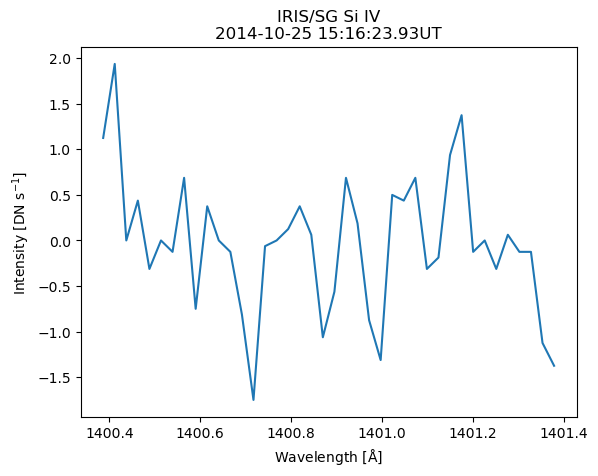

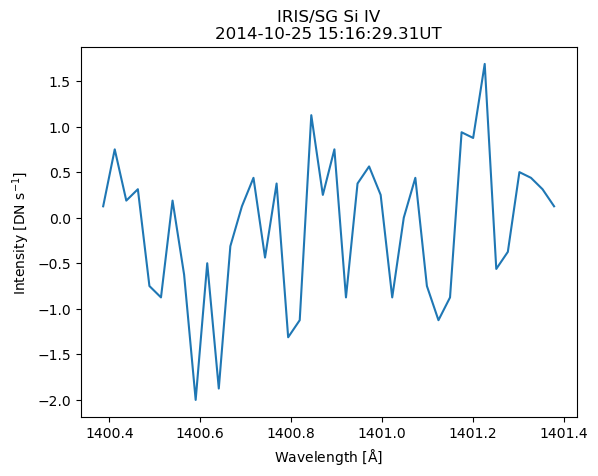

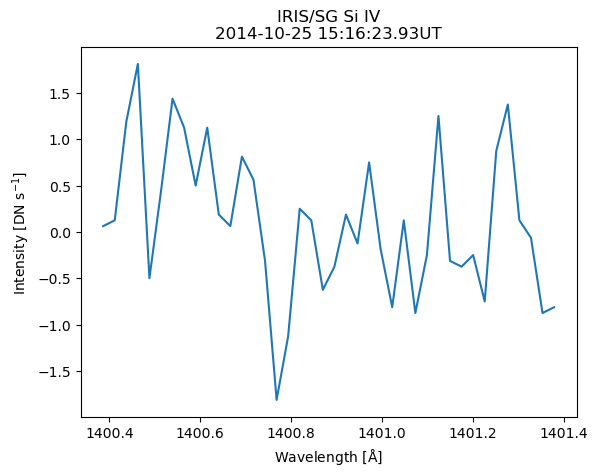

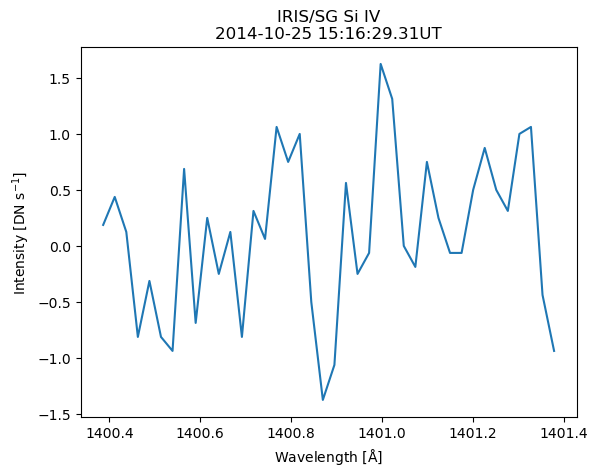

In [5]:
wl = sg_siiv1394_dict['wl'][:,sind]

lowerlim,upperlim = 1400.38,1401.4 #1393.7, 1401.1, 1402.7
 
wind1 = np.abs(wl - lowerlim).argmin()
 
wind2 = np.abs(wl - upperlim).argmin()
 
ll = wl[wind1:wind2]
yy = sg_siiv1394_dict['data'][:,:,wind1:wind2,sind] # [slit positiion yind, exposure number tind, wavelength wind, slit index sind]
i = 0

for yind in range(100,102): #ny
    for tind in range(200,202): #nt
        plt.figure(i) #begin plotting, plot a few at a time to observe trends (CREATE FOR LOOP)
        plt.plot(ll,yy[yind,tind,:])
        plt.xlabel('Wavelength [$\mathrm{\AA}$]')
        plt.ylabel('Intensity [DN s$^{-1}$]')
        plt.title('IRIS/SG Si IV\n'+sg_siiv1394_dict['hdr']['dateobs'][tind,sind]+'UT')
        plt.show
        i += 1


#plt.figure(0) #begin plotting, plot a few at a time to observe trends (CREATE FOR LOOP)
#plt.plot(ll,yy[yind,tind,:])
#plt.xlabel('Wavelength [$\mathrm{\AA}$]')
#plt.ylabel('Intensity [DN s$^{-1}$]')
#plt.title('IRIS/SG Si IV\n'+sg_siiv1394_dict['hdr']['dateobs'][tind,sind]+'UT')
#plt.show

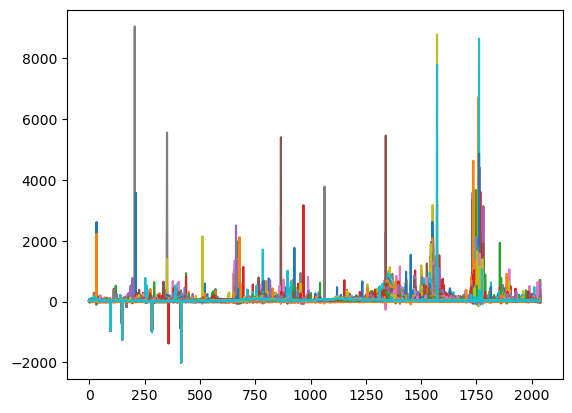

In [6]:
data_temp = np.trapz(sg_siiv1394_dict['data'][:,:,wind1:wind2+1,0],axis=2)

#plt.plot(data_temp[48,1300:1800])
#plt.plot(data_temp[220,1300:1800])
for i in range(20,320):
    #plt.figure(i)
    plt.plot(data_temp[i,:])

In [17]:
print(np.shape(ll))

(40,)


In [19]:
timer_tmp = sg_siiv1394_dict['hdr']['dateobs'][:,0]
### NOTE THAT WE GRABBED 1300:1800 in the time array
timer = pd.to_datetime(timer_tmp[1300:1800])

### this gives you
##      delta_t = the difference (in seconds) between successive element in the array
##      delta_t_basem = the difference (in minutes) between each element in the array and the first element
##      delta_t_bases = the difference (in seconds) between each element in the array and the first element 

delta_t = np.zeros([len(timer)], dtype = np.float32)
for ii in range(1,len(delta_t)):

    delta_t[ii] = (timer[ii] - timer[ii-1])/np.timedelta64(1,'s')
delta_t_basem = (timer-timer[0])/np.timedelta64(1,'m')
delta_t_bases = (timer-timer[0])/np.timedelta64(1,'s')

In [20]:
from astropy.io.fits import getheader,getval,getdata

fname_out = 'data_for_gordon_SiIV1402_oct242015.fits'
hdr = fits.Header()

wavelength = ll
time = delta_t_bases
data = yy[30:60,1300:1800,:]
#tref = [timer_tmp[1300]]

hdr['wvlength'] = 'Wavelength, Angstrom'
hdr['time'] = 'Time from reference, s'
hdr['data'] = 'data [slit position, time, wvlength], DN/s/px'
#hdr['tref'] = 'Reference time; all times in seconds after this point'
empty_primary = fits.PrimaryHDU(header=hdr)

image_hdu1 = fits.PrimaryHDU(wavelength,header = hdr)
image_hdu2 = fits.ImageHDU(time)
image_hdu3 = fits.ImageHDU(data) 
#image_hdu4 = fits.ImageHDU(tref)

hdul = fits.HDUList([image_hdu1,image_hdu3,image_hdu2])
#hdul = fits.HDUList([image_hdu1,image_hdu3,image_hdu2,image_hdu4])
hdul.writeto(fname_out, overwrite=True)

In [45]:
timer_tmp = sg_siiv1394_dict['hdr']['dateobs'][:,0]
timer_tmp[100]
delta_t
delta_t_basem
delta_t_bases
timer_tmp[1300]
timer_tmp[1800]

'2014-10-25 17:39:27.36'

In [15]:
#trapz integrate intensity over wavelength, then create histogram using matplotlib, determine threshold from there and select only slit positions (yind) and exposure times (tind) at or above threshold.

#nny = threshold ny
#nnt = threshold nt, suggest for where intensity = 20

help(sp.integrate.trapezoid)
sp.integrate.trapezoid()

Help on function trapezoid in module scipy.integrate._quadrature:

trapezoid(y, x=None, dx=1.0, axis=-1)
    Integrate along the given axis using the composite trapezoidal rule.
    
    If `x` is provided, the integration happens in sequence along its
    elements - they are not sorted.
    
    Integrate `y` (`x`) along each 1d slice on the given axis, compute
    :math:`\int y(x) dx`.
    When `x` is specified, this integrates along the parametric curve,
    computing :math:`\int_t y(t) dt =
    \int_t y(t) \left.\frac{dx}{dt}\right|_{x=x(t)} dt`.
    
    Parameters
    ----------
    y : array_like
        Input array to integrate.
    x : array_like, optional
        The sample points corresponding to the `y` values. If `x` is None,
        the sample points are assumed to be evenly spaced `dx` apart. The
        default is None.
    dx : scalar, optional
        The spacing between sample points when `x` is None. The default is 1.
    axis : int, optional
        The axis along 

(387, 2040, 1020, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

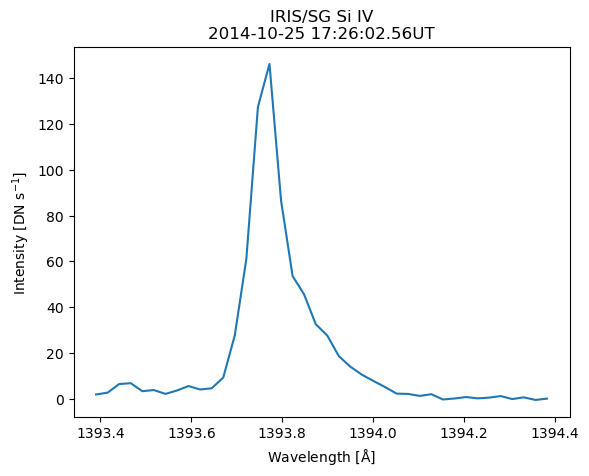

In [5]:
wl = sg_siiv1394_dict['wl'][:,sind]
 
wind1 = np.abs(wl - 1393.4).argmin() #1401.5
 
wind2 = np.abs(wl - 1394.4).argmin() #1403
 
ll = wl[wind1:wind2]
yy = sg_siiv1394_dict['data'][:,:,wind1:wind2,sind] # [slit positiion yind, exposure number tind, wavelength wind, slit index sind]

print(np.shape(sg_siiv1394_dict['data']))

plt.figure(0) #begin plotting, plot a few at a time to observe trends (CREATE FOR LOOP)
plt.plot(ll,yy[yind,tind,:])
plt.xlabel('Wavelength [$\mathrm{\AA}$]')
plt.ylabel('Intensity [DN s$^{-1}$]')
plt.title('IRIS/SG Si IV\n'+sg_siiv1394_dict['hdr']['dateobs'][tind,sind]+'UT')
plt.show

In [8]:
#saving the array

print(np.shape(yy))
filepath = dir1+r'SiIV1394_oct252014.txt'
print(filepath)
open(filepath, "w")
#np.savetxt(filepath, yy)
# matrice to 2D matrice.
yy2D = yy.reshape(yy.shape[0], -1)

print(np.shape(yy2D))

# saving reshaped array to file.
np.savetxt(filepath, yy2D)

# retrieving data from file.
#yyLoad = np.loadtxt(filepath)

#yy3D = yyLoad.reshape(
#    yyLoad.shape[0], yyLoad.shape[1] // yy.shape[2], yy.shape[2])
#print(np.shape(yy3D))

(387, 2040, 40)
E:\\Simon_Files\\oct252014\\SiIV1394_oct252014.txt
(387, 81600)


In [24]:
N_Ele = len(ll)
sum = 0
for i in range(0,N_Ele):
    #print(ll[i])
    #print(yy[yind,tind,i])
    sum += ll[i]*yy[yind,tind,i]
mean = sum/N_Ele

stdev = 0
for i in range(0,N_Ele):
    stdev += np.sqrt((1/N_Ele)*((yy[yind,tind,i]-mean)**2))
kurt = 0
for i in range(0,N_Ele):
    kurt += (((yy[yind,tind,i]-mean)**4)/(stdev**4)) - 3

print(sum, mean, stdev, kurt)

405662.1524412039 10141.553811030097 64094.799483894 -119.97499974363629
